# Machine Learning Augmented Memory Allocation with DQL and Compartmentalization on Traces of Integer Sorting (s=1000)

In [1]:
import collections
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import networkx as nx
import random
from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## LRU simulator

In [2]:
def run_lru(cache_dict, cache_size, seq, start, box_width, hit_cost, miss_cost):   
    i = start
    remain_width = box_width
    while remain_width>0:
        if seq[i] in cache_dict.keys():
            remain_width=remain_width-hit_cost
            cache_dict.move_to_end(seq[i], last=False)
        else:
            remain_width=remain_width-miss_cost
            cache_dict[seq[i]]=True
            cache_dict.move_to_end(seq[i], last=False)
            if len(cache_dict.keys())>cache_size:
                cache_dict.popitem(last=True)
        i = i+1
        if i == len(seq):
            break
    return i # Where the box ends/The position of the next request in the sequence 

## Build feature vector
We use w (window_size) requests r[i-w], r[i-w+1], …, r[i-1] to build the feature vector of the i-th request r[i]. The length of the vector is w+4. 
When 1<=j<=w, the j-th variable of the vector is the frequency of the j-th most frequent page id among r[i-w], r[i-w+1], …, r[i-1]. 
We chop the w requests into four segments of length w/4. Count how many distinct ids in each segment, and put the countings in the last four variables.

In [3]:
def get_vector(seq, pointer_position, window_size):
    vector = []
    if pointer_position == 0:
        for i in range(window_size + 4):
            vector.append(0.00)
    else:
        if pointer_position < window_size:
            window = seq[0:pointer_position]
        else:
            window = seq[pointer_position - window_size:pointer_position]
        frequency = {}
        distinct = {}
        segs_distinct = [0.00, 0.00, 0.00, 0.00] # chop the window into 4 segments 
        #count how many distinct page ids in each seg 
        
        i=0
        seg_id = 0
        while i < len(window):
            if window[i] in frequency.keys():
                frequency[window[i]] = frequency[window[i]] + 1.00
            else:
                frequency[window[i]] = 1.00
            distinct[window[i]] = True
            if (i+1) % (int(window_size / 4)) == 0:
                segs_distinct[seg_id] = len(distinct.keys())
                distinct = {}
                seg_id = seg_id + 1
            i = i + 1
        
        if len(distinct.keys()) > 0:
            segs_distinct[seg_id] = len(distinct.keys())
        
        # 1<=j<=w, the j-th variable of the vector is the frequency of the j-th most frequent page id in 
        # the window
        for v in frequency.values():
            vector.append(v)
        while len(vector) < window_size:
            vector.append(0)
        vector.sort(reverse=True)
        
        # We chop the w requests into four segments of length w/4. 
        # Count how many distinct ids in each segment, and put the countings in the last four variables.
        for v in segs_distinct:
            vector.append(v)
    return vector

## Deep Q network

In [4]:
class DQN(nn.Module):
    def __init__(self, window_size, num_of_box_kind):
        super().__init__()
        self.conv1 = nn.Conv1d(window_size+4, 512, 1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_of_box_kind)
        # print('.........'+str(num_of_box_kind))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(torch.transpose(x,1,2))
        x = self.conv2(torch.transpose(x,1,2))
        x = self.pool(torch.transpose(x,1,2))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

## Deep Q learning 
########## Cells below based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html# . 
I note my modification by comment.

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# Maverick: I add a no_more_random. 
# In the final epochs of training, I can choose to ban the model from acting randomly.
# Guarantee the model converge.
def select_action(state, steps_done, EPS_START, EPS_END, 
                  EPS_DECAY, no_more_random, num_of_box_kinds):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or no_more_random:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return torch.argmax(policy_net(state)), steps_done
    else:
        return torch.tensor([[random.randrange(num_of_box_kinds)]], device=device, dtype=torch.long), steps_done

In [7]:
def optimize_model(memory, BATCH_SIZE, ALPHA, GAMMA, policy_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return policy_net, optimizer
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #print(state_batch.shape)
    state_action_values = policy_net(state_batch).gather(0, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    nsv=target_net(non_final_next_states).max(1)[0].detach()
    lst=[]
    for row in nsv:
        lst.append(torch.argmax(row)*1.00)
    next_state_values[non_final_mask] = torch.tensor(lst,device=device)
    # Compute the expected Q values
    
    ##############################################
    ## Maverick: I add learning rate ALPHA here ##
    ##############################################
    expected_state_action_values = ALPHA*((next_state_values * GAMMA) + reward_batch)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return policy_net, optimizer

########## Cells above based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html# . 

## Training epochs
Train several models.
<br>
Pick the best.

In [10]:
seq=[]
for i in range(10000):
    seq.append(i%64)

In [11]:
f = open("seq-sort10k.ssv")
data = f.readline()
seq=data.split(' ')
print(seq[:10])
print(len(seq))

['0', '1000', '0', '1999', '1000', '1999', '1999', '0', '0', '0']
400961


In [12]:
BATCH_SIZE = 8
GAMMA = 0.3
EPS_START = 0.9
EPS_END = 0.00001
EPS_DECAY = 500
TARGET_UPDATE = 5
window_size=256
miss_cost = 1000 ##################
# number_of_box_kinds = min(8,math.ceil(math.log2(miss_cost))) #############
number_of_box_kinds=8
NUMBER_OF_MODELS = 10 # Train several models, choose the best
num_episodes = 30
ALPHA = 0.8 # Learning rate #########################

In [13]:
features = []
for i in range(len(seq)):
    features.append(get_vector(seq, i, window_size))

In [14]:
best_result=[math.inf for _ in range(num_episodes)]
best_hist = [0 for _ in range(number_of_box_kinds)]
print(len(best_result))
best_policy_net = DQN(window_size,number_of_box_kinds).to(device)
best_target_net = DQN(window_size,number_of_box_kinds).to(device)

for model in range(NUMBER_OF_MODELS):
    global_lru=collections.OrderedDict()
    steps_done = 0
    policy_net = DQN(window_size,number_of_box_kinds).to(device)
    target_net = DQN(window_size,number_of_box_kinds).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters())
    memory = ReplayMemory(10000)
    result = []
    hist = [0 for _ in range(number_of_box_kinds)] 

    for i_episode in range(num_episodes):
        for xx in range(number_of_box_kinds):
            hist[xx]=0
        pointer = 0
        impact = 0
        while pointer < len(seq):
            startpointer = pointer
            state = features[pointer]
            state = torch.tensor([[state]], device=device)
            state = torch.transpose(state,1,2)
            action, steps_done = select_action(state,steps_done,EPS_START,EPS_END,EPS_DECAY,
                                               (i_episode+1)/num_episodes>0.9,number_of_box_kinds)
            box_id=action
            # print(box_id)
            hist[box_id]=hist[box_id]+1
            cache_size=2**box_id
            box_width = miss_cost*cache_size
            
            # Compartmentalization
            # Load top pages from LRU stack.
            mycache = collections.OrderedDict()
            for pid in global_lru.keys():
                mycache[pid]=True
                mycache.move_to_end(pid, last=True)###########
                if len(mycache)==cache_size:
                    break

            action = torch.tensor([[[action]]], device=device) # make it a tensor
            pointer =run_lru(mycache, cache_size, seq, pointer, box_width, 1, miss_cost)
            endpointer = pointer
            
            # Update global stack
            for x in range(startpointer, endpointer):
                if seq[x] in global_lru.keys():
                    global_lru.move_to_end(seq[x], last=False)
                else:
                    global_lru[seq[x]]=True
                    global_lru.move_to_end(seq[x], last=False)
                    
            # print(mi)
            area = 3*miss_cost*cache_size*cache_size
            impact=impact+area
            reward = torch.tensor([[[-area]]], device=device)

            if pointer < len(seq):
                next_state = features[pointer]
                next_state = torch.tensor([[next_state]], device=device)
                next_state = torch.transpose(next_state,1,2)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            policy_net, optimizer=optimize_model(memory, BATCH_SIZE, ALPHA, GAMMA, policy_net, optimizer)

        # Update the target network, copying all weights and biases in DQN
        clear_output()
        print(best_result[-1])
        print('MODEL-'+str(model))
        print('epoch='+str(i_episode)+'..........impact='+str(impact))
        result.append(impact.item())


        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Complete')
    if result[-1]<best_result[-1]:
        for idx in range(len(result)):
            best_result[idx]=result[idx]
        for idx in range(len(hist)):
            best_hist[idx]=hist[idx]
            
        # store the best for further use
        best_policy_net.load_state_dict(policy_net.state_dict())
        best_target_net.load_state_dict(target_net.state_dict())
        
print(best_hist)

331152000
MODEL-9
epoch=29..........impact=tensor(1003008000, device='cuda:0')
Complete
[0, 0, 6899, 0, 0, 0, 0, 0]


## Random box picking
Randomly and uniformly pick one box when needed.

In [15]:
total_impact=0
rounds=1000
for _ in range(rounds):
    pointer=0
    global_lru=collections.OrderedDict()
    while pointer < len(seq):
        startpointer = pointer
        box=random.randint(0,number_of_box_kinds-1)
        cache_size=2**box
        box_width=miss_cost*cache_size
        # Compartmentalization
        # Load top pages from LRU stack.
        mycache = collections.OrderedDict()
        for pid in global_lru.keys():
            mycache[pid]=True
            mycache.move_to_end(pid, last=True)###########
            if len(mycache)==cache_size:
                break
                
        pointer =run_lru(mycache,cache_size, seq, pointer, box_width, 1, miss_cost)
        endpointer = pointer
            
        # Update global stack
        for x in range(startpointer, endpointer):
            if seq[x] in global_lru.keys():
                global_lru.move_to_end(seq[x], last=False)
            else:
                global_lru[seq[x]]=True
                global_lru.move_to_end(seq[x], last=False)
                
        mi=3*miss_cost*cache_size*cache_size
        total_impact=total_impact+mi
print(total_impact/rounds)
rnd=[total_impact/rounds for _ in range(num_episodes)]

3847934436.0


## Michael Bender's algorithm

In [16]:
# Michael's algorithm 
MAXBOX=number_of_box_kinds-1
countings = [0 for i in range(MAXBOX+1)]
countings[0]=1
currentbox=0
pointer=0
ggg=0
global_lru=collections.OrderedDict()
while pointer < len(seq):
    startpointer=pointer
    cache_size=2**currentbox
    box_width=miss_cost*cache_size
    # Compartmentalization
    # Load top pages from LRU stack.
    mycache = collections.OrderedDict()
    for pid in global_lru.keys():
        mycache[pid]=True
        mycache.move_to_end(pid, last=True)###########
        if len(mycache)==cache_size:
            break
            
    pointer =run_lru(mycache,cache_size, seq, pointer, box_width, 1, miss_cost)
    endpointer = pointer
            
    # Update global stack
    for x in range(startpointer, endpointer):
        if seq[x] in global_lru.keys():
            global_lru.move_to_end(seq[x], last=False)
        else:
            global_lru[seq[x]]=True
            global_lru.move_to_end(seq[x], last=False)
                
    mi=3*miss_cost*cache_size*cache_size
    ggg=ggg+mi
    if currentbox==MAXBOX:
        currentbox=0
    elif countings[currentbox]%4==0:
        currentbox=currentbox+1
    else:
        currentbox=0
    countings[currentbox]=countings[currentbox]+1
    
michael=[ggg for hhh in range(num_episodes)]
print(ggg)

707784000


## Offline opt

In [17]:
############################
# run lru, mark down hits and faults
def LRU(sequence, size):
    stack = collections.OrderedDict()
    marks = []
    for r in sequence:
        if r in stack.keys():
            marks.append(True)  # a hit
        else:
            if len(stack.keys()) == size:  # memory is full
                stack.popitem(last=True)
            marks.append(False)  # a fault
            stack[r] = True
        stack.move_to_end(r, last=False)
    return marks


############################
# get the request_sequence
request_sequence = seq

# parameters
n = len(request_sequence)
s = miss_cost  # time to handle fault
k = 2**(number_of_box_kinds-1)  # largest memory size

############################
print('building dag...')
# find end indexes
# initialize table
end_index = [[0 for i in range(n)] for j in range(number_of_box_kinds)]
# find end indexes
for i in range(number_of_box_kinds):
    memory_size = math.floor(k / (2 ** i))
    # run lru on the whole sequence
    # with memory_size = k / (2 ** i)
    is_a_hit = LRU(request_sequence, memory_size)
    # find the end index for node[i][0]
    box_width = s * memory_size
    request_position = 0
    actual_running_time = 0
    while actual_running_time < box_width and request_position < n:
        if is_a_hit[request_position]:
            actual_running_time += 1
        else:
            actual_running_time += s
        request_position += 1
    end_index[i][0] = request_position - 1
    # find end indexes for other nodes in row i
    for j in range(1, n):
        if is_a_hit[j - 1]:
            actual_running_time = actual_running_time - 1
            if actual_running_time < box_width:
                end_index[i][j] = min(end_index[i][j - 1] + 1, n - 1)
            else:
                end_index[i][j] = end_index[i][j - 1]
        else:
            actual_running_time = actual_running_time - s
            spared_time = box_width - actual_running_time
            request_position = end_index[i][j - 1] + 1
            while request_position < n and spared_time > 0:
                if is_a_hit[request_position]:
                    spared_time -= 1
                else:
                    spared_time -= s
                request_position += 1
            end_index[i][j] = request_position - 1
        if end_index[i][j] > end_index[i][j - 1]:
            for ii in range(1 + end_index[i][j - 1], 1 + end_index[i][j]):
                if is_a_hit[ii]:
                    actual_running_time += 1
                else:
                    actual_running_time += s

#########################################
# turn the table to dag
dag = nx.Graph()
for i in range(number_of_box_kinds):
    dag.add_edge('start', str(i) + '-0', weight=0)
for i in range(number_of_box_kinds):
    for j in range(n):
        if end_index[i][j] < (n - 1):
            for ii in range(number_of_box_kinds):
                dag.add_edge(str(i) + '-' + str(j),
                             str(ii) + '-' + str(end_index[i][j] + 1),
                             weight=3 * s * (k / (2 ** i)) ** 2)
        else:
            dag.add_edge(str(i) + '-' + str(j), 'end',
                         weight=3 * s * (k / (2 ** i)) ** 2)
print('searching the shortest path...')
#p = nx.dijkstra_path(dag, source='start', target='end')
d = nx.dijkstra_path_length(dag, source='start', target='end')
#print(p)
print(d)
opt=[d for _ in range(num_episodes)]

building dag...
searching the shortest path...
286872000.0


C:\Users\TIANCH~1\AppData\Local\Temp/ipykernel_657496/1431221090.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


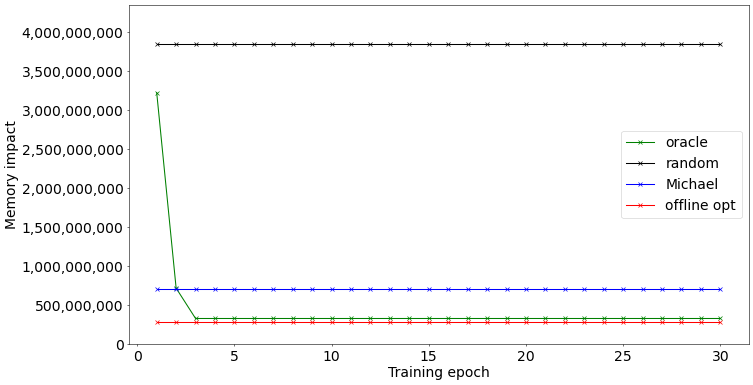

In [20]:
plt.figure(figsize=(16,9),dpi=50)
plt.xlabel('Training epoch',fontsize=20)
plt.ylabel('Memory impact',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,max(max(rnd), max(best_result), max(michael))+500000000)
plt.plot([x for x in range(1, len(best_result)+1)], best_result, label='oracle',
         linestyle='-', color='g', marker='x', linewidth=1.5)
plt.plot([x for x in range(1, len(rnd)+1)], rnd, label='random',
         linestyle='-', color='k', marker='x', linewidth=1.5)
plt.plot([x for x in range(1, len(michael)+1)], michael, label='Michael',
         linestyle='-', color='b', marker='x', linewidth=1.5)
plt.plot([x for x in range(1, len(opt)+1)], opt, label='offline opt',
         linestyle='-', color='r', marker='x', linewidth=1.5)
plt.ticklabel_format(style='plain', axis='both')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.legend(fontsize=20)